# Training Decision Transformers with 🤗 transformers

In [22]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In this tutorial, **you’ll learn to train your first Offline Decision Transformer model from scratch to make a half-cheetah run.** 🏃

❓ If you have questions, please post them on #study-group discord channel 👉 https://discord.gg/aYka4Yhff9

🎮 Environments:
- [Half Cheetah](https://www.gymlibrary.dev/environments/mujoco/half_cheetah/)

⬇️ Here's what you'll achieve at the end of this tutorial. ⬇️

### Prerequisites 🏗️
Before diving into the notebook, you need to:

🔲 📚 [Read the tutorial](https://huggingface.co/blog/train-decision-transformers)

### Step 1: Install dependencies for model evaluation 🔽

In [10]:
!sudo apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common \
    patchelf \
    xvfb

### Step 2: Install and import the packages 📦



In [4]:
!pip install gym==0.21.0
!pip install free-mujoco-py
!pip install transformers
!pip install datasets
!pip install imageio-ffmpeg

!pip install colabgymrender==1.0.2
!pip install xvfbwrapper
!pip install imageio==2.4.1
!pip install imageio-ffmpeg
!pip install huggingface_hub


In [1]:
import os
import random
from dataclasses import dataclass
import copy
import h5py
from datasets import Dataset, Image
import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset, concatenate_datasets, load_from_disk
import datasets
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

/home/tuan/Desktop/FPT/doan/doan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 3: Loading the dataset from the 🤗 Hub and instantiating the model

We host a number of Offline RL Datasets on the hub. Today we will be training with the halfcheetah “expert” dataset, hosted here on hub.

First we need to import the load_dataset function from the 🤗 datasets package and download the dataset to our machine.

In [4]:
os.environ["WANDB_DISABLED"] = "true" # we diable weights and biases logging for this tutorial
# dataset = load_from_disk(f"/content/drive/MyDrive/hdf5_dm_test_auto_1022.hf")

In [ ]:
# a = dataset['train'].to_pandas()
# len(a['observations'])
# print(len(a))
# print(type(a))
#in example, ['train'] is train;
#[0] is one sample, not one time frame; means one trajectory
#['observations'] is observation in multiple timeframe, typically a trajectory
#[3]a timeframe in one trajectory

In [3]:
import h5py
import numpy as np
from datasets import Dataset, concatenate_datasets
import copy

def hdf5_to_arrow_multiple(hdf5_files):
    d = {}
    dataset = Dataset.from_dict(d)
    for hdf5_file in hdf5_files:
        #1000 is the length of data
        one_time_only = True
        col_state = []
        col_action = []
        col_reward = []
        with h5py.File(hdf5_file, 'r') as f:
            # d = {}
            # dataset = Dataset.from_dict(d)
            state = []
            action = []
            reward = []
            for frame_idx in range(1000):
                helperarr = f[f'frame_{frame_idx}_helperarr'][:].tolist()
                if helperarr  == [0,1]:
                    helperarr = -1
                elif helperarr  == [1,0]:
                    helperarr = 1
                else:
                    helperarr = 0
                x = f[f'frame_{frame_idx}_x'][:]
                xaux = f[f'frame_{frame_idx}_xaux'][:]
                y = f[f'frame_{frame_idx}_y'][:]
                # if in testing, gun fire is semi, try this
                # if frame_idx != 0 and frame_idx != 1000 and f[f'frame_{frame_idx-1}_y'][11] == 1 and f[f'frame_{frame_idx+1}_y'][11] == 1:
                #    f[f'frame_{frame_idx}_y'][11] == 1
                # if frame_idx != 0 and frame_idx != 999 and frame_idx != 1000 and f[f'frame_{frame_idx-1}_y'][11] == 1 and f[f'frame_{frame_idx+2}_y'][11] == 1: # if in testing, gun fire is semi, try this
                #    f[f'frame_{frame_idx}_y'][11] == 1
                #    f[f'frame_{frame_idx+1}_y'][11] == 1

                state.append(np.concatenate((f[f'frame_{frame_idx}_xaux'][15:18],np.mean(x,-1).flatten()))) # change color to grey and chang it to one dimension then add health, armor, ammo to the state
                action.append(y)
                reward.append(helperarr)
                # Extract trajectories and calculate rewards
                # if helperarr  == -1 or frame_idx == 999:
                if (1 + frame_idx) % 50 == 0:
                    print('end trajectory')
                    # trajectory = {
                    #     'observations': state,
                    #     'actions':action,
                    #     'reward': reward}
                    col_state.append(state)
                    col_action.append(action)
                    col_reward.append(reward)
                    #creat dataset in here to reduce ram usage in return of longer runtime
                    datatemp = Dataset.from_dict({"observations": [state], "actions": [action], 'rewards': [reward]})
                    if one_time_only:
                        dataset = copy.deepcopy(datatemp)
                        one_time_only = False
                    else:
                        dataset = concatenate_datasets([dataset, datatemp])
                    state = []
                    action = []
                    reward = []

    # dataset = Dataset.from_dict({"observations": col_state, "actions": col_action, 'rewards': col_reward})
    return dataset


    # one_time_only = True
    # dataset = None  # Initialize dataset variable to store the concatenated datasets

    # for hdf5_file in hdf5_files:
    #     with h5py.File(hdf5_file, 'r') as f:
    #         state = []
    #         action = []
    #         reward = []
    #         d = {}
    #         dataset = Dataset.from_dict(d)

    #         for frame_idx in range(1000):
    #             helperarr = f[f'frame_{frame_idx}_helperarr'][:].tolist()
    #             if helperarr  == [0,1]:
    #                 helperarr = -1
    #             elif helperarr  == [1,0]:
    #                 helperarr = 1
    #             else:
    #                 helperarr = 0

    #             x = f[f'frame_{frame_idx}_x'][:]
    #             y = f[f'frame_{frame_idx}_y'][:]
    #             # if in testing, gun fire is semi, try this
    #             # if frame_idx != 0 and frame_idx != 1000 and f[f'frame_{frame_idx-1}_y'][11] == 1 and f[f'frame_{frame_idx+1}_y'][11] == 1:
    #             #    f[f'frame_{frame_idx}_y'][11] == 1
    #             # if frame_idx != 0 and frame_idx != 999 and frame_idx != 1000 and f[f'frame_{frame_idx-1}_y'][11] == 1 and f[f'frame_{frame_idx+2}_y'][11] == 1: # if in testing, gun fire is semi, try this
    #             #    f[f'frame_{frame_idx}_y'][11] == 1
    #             #    f[f'frame_{frame_idx+1}_y'][11] == 1
    #             state.append(np.concatenate((f[f'frame_{frame_idx}_xaux'][15:18], np.mean(x, -1).flatten())))
    #             action.append(y)
    #             reward.append(helperarr)
    #             # Extract trajectories and calculate rewards
    #             # if helperarr  == -1 or frame_idx == 999:
    #             if (frame_idx + 1) % 50 == 0:
    #                 print('end trajectory')
    #                 #creat dataset in here to reduce ram usage in return of longer runtime
    #                 datatemp = Dataset.from_dict({"observations": [state], "actions": [action], 'rewards': [reward]})

    #                 # Concatenate data from each file
    #                 if one_time_only:
    #                     dataset = copy.deepcopy(datatemp)
    #                     one_time_only = False
    #                 else:
    #                     dataset = concatenate_datasets([dataset, datatemp])

    #                 # Reset temporary lists
    #                 state = []
    #                 action = []
    #                 reward = []
    # # dataset = Dataset.from_dict({"observations": col_state, "actions": col_action, 'rewards': col_reward})
    # return dataset

# Example usage with multiple files
# hdf5_files = [
#     '/home/tuan/Desktop/FPT/doan/cs2_data/hdf5_dm_test_auto_1.hdf5',
#     '/home/tuan/Desktop/FPT/doan/cs2_data/hdf5_dm_test_auto_2.hdf5',
#     '/home/tuan/Desktop/FPT/doan/cs2_data/hdf5_dm_test_auto_3.hdf5'
# ]
hdf5_files = [
    '/home/tuan/Desktop/FPT/doan/cs2_data/hdf5_dm_test_auto_1.hdf5',

]
dataset = hdf5_to_arrow_multiple(hdf5_files)
dataset.save_to_disk("/home/tuan/Desktop/FPT/doan/hdf5_dm_test_auto_combined.hf")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/tuan/Desktop/FPT/doan/cs2_data/hdf5_dm_test_auto_1.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
def hdf5_to_arrow(hdf5_file):
    #1000 is the length of data
    one_time_only = True
    col_state = []
    col_action = []
    col_reward = []
    with h5py.File(hdf5_file, 'r') as f:
        d = {}
        dataset = Dataset.from_dict(d)
        state = []
        action = []
        reward = []
        for frame_idx in range(1000):
            helperarr = f[f'frame_{frame_idx}_helperarr'][:].tolist()
            if helperarr  == [0,1]:
              helperarr = -1
            elif helperarr  == [1,0]:
              helperarr = 1
            else:
              helperarr = 0
            x = f[f'frame_{frame_idx}_x'][:]
            xaux = f[f'frame_{frame_idx}_xaux'][:]
            y = f[f'frame_{frame_idx}_y'][:]
            # if in testing, gun fire is semi, try this
            # if frame_idx != 0 and frame_idx != 1000 and f[f'frame_{frame_idx-1}_y'][11] == 1 and f[f'frame_{frame_idx+1}_y'][11] == 1:
            #    f[f'frame_{frame_idx}_y'][11] == 1
            # if frame_idx != 0 and frame_idx != 999 and frame_idx != 1000 and f[f'frame_{frame_idx-1}_y'][11] == 1 and f[f'frame_{frame_idx+2}_y'][11] == 1: # if in testing, gun fire is semi, try this
            #    f[f'frame_{frame_idx}_y'][11] == 1
            #    f[f'frame_{frame_idx+1}_y'][11] == 1

            state.append(np.concatenate((f[f'frame_{frame_idx}_xaux'][15:18],np.mean(x,-1).flatten()))) # change color to grey and chang it to one dimension then add health, armor, ammo to the state
            action.append(y)
            reward.append(helperarr)
            # Extract trajectories and calculate rewards
            # if helperarr  == -1 or frame_idx == 999:
            if (1 + frame_idx) % 50 == 0:
                print('end trajectory')
                # trajectory = {
                #     'observations': state,
                #     'actions':action,
                #     'reward': reward}
                col_state.append(state)
                col_action.append(action)
                col_reward.append(reward)
                #creat dataset in here to reduce ram usage in return of longer runtime
                datatemp = Dataset.from_dict({"observations": [state], "actions": [action], 'rewards': [reward]})
                if one_time_only:
                  dataset = copy.deepcopy(datatemp)
                  one_time_only = False
                else:
                  dataset = concatenate_datasets([dataset, datatemp])
                state = []
                action = []
                reward = []

    # dataset = Dataset.from_dict({"observations": col_state, "actions": col_action, 'rewards': col_reward})
    return dataset

# # Example usage
# hdf5_file = f'/content/drive/MyDrive/cs2_data/hdf5_dm_test_auto_1.hdf5'
# dataset = hdf5_to_arrow(hdf5_file)
# dataset.save_to_disk(f"/content/drive/MyDrive/cs2_data/hdf5_dm_test_auto_1.hf")

In [6]:
import glob
save_dir = 'raw_data/'
index = 0
dataset_full = None
for files in glob.glob(save_dir + '*'):
    dataset = hdf5_to_arrow(files)
    if index == 0:
        dataset_full = copy.deepcopy(dataset)
    else:
        dataset_full = concatenate_datasets([dataset_full, dataset])
        if index % 4 == 0:
            dataset.save_to_disk(f"hdf5_dm_test_auto_combine.hf")
    index += 1
    print(index)

end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
1
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
2
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
3
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end trajectory
end 

Saving the dataset (1/1 shards): 100%|██████████| 20/20 [00:00<00:00, 41.21 examples/s]

5


In [ ]:
# plt.imshow(np.array(dataset[1]['observations'][15]), cmap=cm.gray)
# for n in range(len(dataset)):
#   print(len(dataset[n]['rewards']))

In [35]:
f = h5py.File(f'/content/drive/MyDrive/hdf5_dm_test_auto_1022.hdf5', 'r')
#1000 frame (0-999)
# Accessing the first frame's datasets
#frame_helperarr = f['frame_0_helperarr'][:]  # Reading the helper array
frame_x = f['frame_100_x'][:]  # Reading the image data AKA state
frame_xaux = f['frame_100_xaux'][:]  # Reading auxiliary data

frame_y = f['frame_100_y'][:]  # Reading the y data AKA action
frame_x

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/hdf5_dm_test_auto_1022.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [71]:
states = []
states.extend(dataset['actions'][4])
states

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.

In [123]:
def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])

In [124]:
dim(dataset[0]["actions"][0])

[51]

### Step 4: Defining a custom DataCollator for the transformers Trainer class

In [7]:
@dataclass
class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 20 #subsets of the episode we use for training
    state_dim: int = 61803  # size of state space
    act_dim: int = 51  # size of action space
    max_ep_len: int = 1000 # max episode length in the dataset
    scale: float = 1000.0  # normalization of rewards/returns
    state_mean: np.array = None  # to store state means
    state_std: np.array = None  # to store state stds
    p_sample: np.array = None  # a distribution to take account trajectory lengths
    n_traj: int = 0 # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:        
        self.act_dim = len(dataset[0]["actions"][0])
        self.state_dim = len(dataset[0]["observations"][0])
        self.dataset = dataset
        # calculate dataset stats for normalization of states
        states = []
        traj_lens = []
        for obs in dataset["observations"]:
            states.extend(obs)
            traj_lens.append(len(obs))
        self.n_traj = len(traj_lens)
        states = np.vstack(states)
        self.state_mean, self.state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6

        traj_lens = np.array(traj_lens)
        self.p_sample = traj_lens / sum(traj_lens)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(
            np.arange(self.n_traj),
            size=batch_size,
            replace=True,
            p=self.p_sample,  # reweights so we sample according to timesteps
        )
        # a batch of dataset features
        s, a, r, rtg, timesteps, mask = [], [], [], [], [], []

        for ind in batch_inds:
            # for feature in features:
            feature = self.dataset[int(ind)]
            si = random.randint(0, len(feature["rewards"]) - 1) #random starting index for each selected trajectory.

            # get sequences from dataset
            s.append(np.array(feature["observations"][si : si + self.max_len]).reshape(1, -1, self.state_dim)) # take max_len time frames from starting index(si)
            a.append(np.array(feature["actions"][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature["rewards"][si : si + self.max_len]).reshape(1, -1, 1))

            # d.append(np.array(feature["dones"][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature["rewards"][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            # print(rtg[-1].shape[1])
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            # print(s[-1].shape)
            # print(tlen)
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - self.state_mean) / self.state_std
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            # d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1) / self.scale
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        # d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

### Step 5: Extending the Decision Transformer Model to include a loss function

In order to train the model with the 🤗 trainer class, we first need to ensure the dictionary it returns contains a loss, in this case L-2 norm of the models action predictions and the targets.

In [26]:
def custom_loss(y_true, y_pred):
        # y_true is shape [n_batch, n_timesteps, n_keys+n_clicks+n_mouse_x+n_mouse_y+n_reward+n_advantage]
        # where n_reward and n_advantage must =1
        # y_pred is shape [n_batch, n_timesteps, n_keys+n_clicks+n_mouse_x+n_mouse_y+n_val]
        # we'll use y_true to send in reward and eventually original advantage fn (or could recompute this?)

        # wasd keys
        loss1a = losses.binary_crossentropy(y_true[:,:,0:4],
                                            y_pred[:,:,0:4])
        # space key
        loss1b = losses.binary_crossentropy(y_true[:,:,4:5],
                                            y_pred[:,:,4:5])
        # reload key
        loss1c = losses.binary_crossentropy(y_true[:,:,n_keys-1:n_keys],
                                            y_pred[:,:,n_keys-1:n_keys])

        # weapon switches, 1,2,3
        loss1d = losses.binary_crossentropy(y_true[:,:,n_keys-4:n_keys-1],
                                            y_pred[:,:,n_keys-4:n_keys-1])

        # all other keys
        # loss1d = losses.binary_crossentropy(y_true[:,:,5:n_keys-1],
        #                                     y_pred[:,:,5:n_keys-1])
        # left click
        loss2a = losses.binary_crossentropy(y_true[:,:,n_keys:n_keys+1],
                                            y_pred[:,:,n_keys:n_keys+1])
        # right click
        loss2b = losses.binary_crossentropy(y_true[:,:,n_keys+1:n_keys+n_clicks],
                                            y_pred[:,:,n_keys+1:n_keys+n_clicks])
        # mouse move x
        loss3 = losses.categorical_crossentropy(y_true[:,:,n_keys+n_clicks:n_keys+n_clicks+n_mouse_x],
                                                y_pred[:,:,n_keys+n_clicks:n_keys+n_clicks+n_mouse_x])
        # mouse move y
        loss4 = losses.categorical_crossentropy(y_true[:,:,n_keys+n_clicks+n_mouse_x:n_keys+n_clicks+n_mouse_x+n_mouse_y],
                                                y_pred[:,:,n_keys+n_clicks+n_mouse_x:n_keys+n_clicks+n_mouse_x+n_mouse_y])

        # critic loss -- measuring between consecutive time steps
        #  = ((reward_t + gamma  v_t+1) - v_t)^2
        # can't really decide whether to use reward_t or reward_t+1, but guess it doesn't matter too much
        loss_crit = 10*losses.MSE(y_true[:,:-1,n_keys+n_clicks+n_mouse_x+n_mouse_y:n_keys+n_clicks+n_mouse_x+n_mouse_y+1]
                           + GAMMA*y_pred[:,1:,n_keys+n_clicks+n_mouse_x+n_mouse_y:n_keys+n_clicks+n_mouse_x+n_mouse_y+1]
                           ,y_pred[:,:-1,n_keys+n_clicks+n_mouse_x+n_mouse_y:n_keys+n_clicks+n_mouse_x+n_mouse_y+1])

        return K.concatenate([loss1a, loss1b, loss1c, loss2a, loss3, loss4, loss_crit])

In [126]:
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config, gamma=0.99):
        super().__init__(config)
        self.gamma = gamma

    def forward(self, **kwargs):
        print('here0')
        output = super().forward(**kwargs)
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]

        print("action_preds shape:", action_preds.shape)
        print("action_targets shape:", action_targets.shape)


        # Reshape for custom loss
        n_keys = 11
        n_clicks = 2
        mouse_x_possibles = [-1000.0,-500.0, -300.0, -200.0, -100.0, -60.0, -30.0, -20.0, -10.0, -4.0, -2.0, -0.0, 2.0, 4.0, 10.0, 20.0, 30.0, 60.0, 100.0, 200.0, 300.0, 500.0,1000.0]
        mouse_y_possibles = [-200.0, -100.0, -50.0, -20.0, -10.0, -4.0, -2.0, -0.0, 2.0, 4.0, 10.0, 20.0, 50.0, 100.0, 200.0]
        n_mouse_x = len(mouse_x_possibles)
        n_mouse_y = len(mouse_y_possibles)

        action_preds = action_preds[attention_mask > 0]
        action_targets = action_targets[attention_mask > 0]

        # Loss calculations based on each category
        loss1a = F.binary_cross_entropy(action_preds[:, :4], action_targets[:, :4])
        loss1b = F.binary_cross_entropy(action_preds[:, 4:5], action_targets[:, 4:5])
        loss1c = F.binary_cross_entropy(action_preds[:, n_keys-1:n_keys], action_targets[:, n_keys-1:n_keys])
        loss1d = F.binary_cross_entropy(action_preds[:, n_keys-4:n_keys-1], action_targets[:, n_keys-4:n_keys-1])
        loss2a = F.binary_cross_entropy(action_preds[:, n_keys:n_keys+1], action_targets[:, n_keys:n_keys+1])
        loss2b = F.binary_cross_entropy(action_preds[:, n_keys+1:n_keys+n_clicks], action_targets[:, n_keys+1:n_keys+n_clicks])
        print('here1')
        loss3 = F.cross_entropy(action_preds[:, n_keys+n_clicks:n_keys+n_clicks+n_mouse_x], action_targets[:, n_keys+n_clicks:n_keys+n_clicks+n_mouse_x].argmax(dim=1))
        loss4 = F.cross_entropy(action_preds[:, n_keys+n_clicks+n_mouse_x:n_keys+n_clicks+n_mouse_x+n_mouse_y], action_targets[:, n_keys+n_clicks+n_mouse_x:n_keys+n_clicks+n_mouse_x+n_mouse_y].argmax(dim=1))
        print('here2')
        # Critic loss
        reward_t = action_targets[:, n_keys + n_clicks + n_mouse_x + n_mouse_y : n_keys + n_clicks + n_mouse_x + n_mouse_y + 1]
        v_t = action_preds[:, n_keys + n_clicks + n_mouse_x + n_mouse_y : n_keys + n_clicks + n_mouse_x + n_mouse_y + 1]
        v_t_next = action_preds[:, 1:, n_keys + n_clicks + n_mouse_x + n_mouse_y : n_keys + n_clicks + n_mouse_x + n_mouse_y + 1]

        loss_crit = 10 * F.mse_loss(reward_t[:, :-1] + self.gamma * v_t_next, v_t[:, :-1])
        print('here3')
        # Total loss
        total_loss = sum([loss1a, loss1b, loss1c, loss1d, loss2a, loss2b, loss3, loss4, loss_crit])

        return {"loss": total_loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

action_preds shape: torch.Size([315, 51]) dtype: torch.float32

action_targets shape: torch.Size([315, 51]) dtype: torch.float32

action_preds sample: tensor([ 0.1753, -0.1965, -0.2445, -0.3211,  0.3310,  0.0852,  0.0756, -0.1474,
         0.0823,  0.0814], device='cuda:0', grad_fn=<SliceBackward0>)
         
action_targets sample: tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [8]:
test_value = 0
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        global test_value
        test_value = kwargs
        # print(kwargs)
        print(type(kwargs))
        # print(kwargs.shape)
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]

        # **Debugging Statements**:
        print("action_preds shape:", action_preds.shape, "dtype:", action_preds.dtype)
        print("action_targets shape:", action_targets.shape, "dtype:", action_targets.dtype)
        print("action_preds sample:", action_preds[0, :10])
        print("action_targets sample:", action_targets[0, :10])

        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [9]:
collator = DecisionTransformerGymDataCollator(dataset_full)

config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config)

In [128]:
model

TrainableDT(
  (encoder): DecisionTransformerGPT2Model(
    (wte): Embedding(1, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x DecisionTransformerGPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): DecisionTransformerGPT2Attention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): DecisionTransformerGPT2MLP(
          (c_fc): Conv1D(nf=512, nx=128)
          (c_proj): Conv1D(nf=128, nx=512)
          (act): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (embed_timestep): Embedding(4096, 128)
  (embed_return): Linear(in_features=

In [30]:
# test_value.keys()

AttributeError: 'int' object has no attribute 'keys'

In [ ]:
# test_value["actions"].shape

torch.Size([20, 20, 51])

### Step 6: Defining the training hyperparameters and training the model
Here, we define the training hyperparameters and our Trainer class that we'll use to train our Decision Transformer model.

This step takes about an hour, so you may leave it running. Note the authors train for at least 3 hours, so the results presented here are not as performant as the models hosted on the 🤗 hub.

In [10]:
training_args = TrainingArguments(
    output_dir="./trained_models/",
    remove_unused_columns=False,
    num_train_epochs=120,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_full,
    data_collator=collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
  0%|          | 0/240 [00:00<?, ?it/s]

<class 'dict'>
action_preds shape: torch.Size([1036, 51]) dtype: torch.float32
action_targets shape: torch.Size([1036, 51]) dtype: torch.float32
action_preds sample: tensor([-0.3136, -0.2832, -0.2762,  0.2300, -0.3040,  0.1782, -0.1402,  0.0728,
         0.3049,  0.2600], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


  0%|          | 1/240 [02:14<8:56:59, 134.81s/it]

<class 'dict'>
action_preds shape: torch.Size([561, 51]) dtype: torch.float32
action_targets shape: torch.Size([561, 51]) dtype: torch.float32
action_preds sample: tensor([-0.1460, -0.3046,  0.1718, -0.2603, -0.2478, -0.0522,  0.0171, -0.2396,
         0.1339,  0.0660], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


  1%|▏         | 3/240 [04:31<5:37:47, 85.52s/it] 

<class 'dict'>
action_preds shape: torch.Size([1031, 51]) dtype: torch.float32
action_targets shape: torch.Size([1031, 51]) dtype: torch.float32
action_preds sample: tensor([-0.2919,  0.1829,  0.1558, -0.2505,  0.2847, -0.2647,  0.0158, -0.2955,
        -0.1254, -0.0491], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
<class 'dict'>
action_preds shape: torch.Size([520, 51]) dtype: torch.float32
action_targets shape: torch.Size([520, 51]) dtype: torch.float32
action_preds sample: tensor([ 0.0376,  0.0410,  0.0044, -0.3693, -0.0781, -0.4217,  0.1920, -0.2554,
        -0.1016, -0.5075], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


  2%|▏         | 5/240 [06:47<4:59:28, 76.46s/it]

<class 'dict'>
action_preds shape: torch.Size([1020, 51]) dtype: torch.float32
action_targets shape: torch.Size([1020, 51]) dtype: torch.float32
action_preds sample: tensor([ 0.0897,  0.2966, -0.2781,  0.2756, -0.3582, -0.5010, -0.1810,  0.2319,
        -0.1146, -0.0552], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
<class 'dict'>
action_preds shape: torch.Size([610, 51]) dtype: torch.float32
action_targets shape: torch.Size([610, 51]) dtype: torch.float32
action_preds sample: tensor([ 0.1028,  0.0126, -0.0335, -0.2816,  0.0303,  0.2255,  0.1603, -0.0582,
        -0.3262, -0.0513], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


  3%|▎         | 7/240 [08:59<4:40:03, 72.12s/it]

<class 'dict'>
action_preds shape: torch.Size([1101, 51]) dtype: torch.float32
action_targets shape: torch.Size([1101, 51]) dtype: torch.float32
action_preds sample: tensor([ 0.2204,  0.1718, -0.2221,  0.2577, -0.1081,  0.1107,  0.1242,  0.0143,
        -0.1593,  0.0550], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
<class 'dict'>
action_preds shape: torch.Size([589, 51]) dtype: torch.float32
action_targets shape: torch.Size([589, 51]) dtype: torch.float32
action_preds sample: tensor([-0.0104, -0.0406, -0.3376, -0.1949,  0.0664, -0.1023, -0.1778, -0.2521,
        -0.1302,  0.0712], device='cuda:0', grad_fn=<SliceBackward0>)
action_targets sample: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


KeyboardInterrupt: 

In [ ]:
    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

### Step 7: Visualize the performance of the agent

In [ ]:
import mujoco_py
import gym

from colabgymrender.recorder import Recorder

In [ ]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous 20 timesteps.
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

In [ ]:
# build the environment
directory = './video'
model = model.to("cpu")
env = gym.make("HalfCheetah-v3")
env = Recorder(env, directory, fps=30)
max_ep_len = 1000
device = "cpu"
scale = 1000.0  # normalization for rewards/returns
TARGET_RETURN = 12000 / scale  # evaluation is conditioned on a return of 12000, scaled accordingly

state_mean = collator.state_mean.astype(np.float32)
state_std = collator.state_std.astype(np.float32)
print(state_mean)

state_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
# Create the decision transformer model

state_mean = torch.from_numpy(state_mean).to(device=device)
state_std = torch.from_numpy(state_std).to(device=device)


In [ ]:
# Interact with the environment and create a video
episode_return, episode_length = 0, 0
state = env.reset()
target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
rewards = torch.zeros(0, device=device, dtype=torch.float32)

timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
for t in range(max_ep_len):
    actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
    rewards = torch.cat([rewards, torch.zeros(1, device=device)])

    action = get_action(
        model,
        (states - state_mean) / state_std,
        actions,
        rewards,
        target_return,
        timesteps,
    )
    actions[-1] = action
    action = action.detach().cpu().numpy()

    state, reward, done, _ = env.step(action)

    cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
    states = torch.cat([states, cur_state], dim=0)
    rewards[-1] = reward

    pred_return = target_return[0, -1] - (reward / scale)
    target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
    timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

    episode_return += reward
    episode_length += 1

    if done:
        break


In [ ]:
# Play the video
env.play()
# If you want to convert the video:
# !ffmpeg -i {your_video} -vcodec h264 replay.mp4

### Step 8: Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

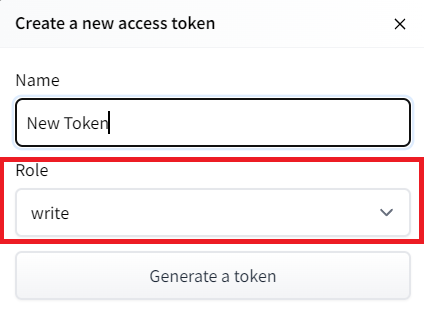

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained model to the 🤗 Hub 🔥 !!

In [ ]:
trainer.push_to_hub()

## Some additional challenges 🏆
Congratulations, you've just trained your first Decision Transformer 🥳.

Now, the best way to learn **is to try things by your own**! Why not trying with another environment?

We provide datasets for some other environments:
* [Walker2D](https://huggingface.co/edbeeching/decision-transformer-gym-walker2d-expert)
* [Hopper](https://huggingface.co/edbeeching/decision-transformer-gym-hopper-expert)


Have fun!

### Keep Learning, Stay awesome 🤗
